In [18]:
### imports

# external modules
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model, Sequential, load_model
import importlib
import pickle
import math
from sklearn.preprocessing import StandardScaler

# local modules
sys.path.append('../utils')
import csv_utils as csvu
import json_utils as jsonu
import dataframe_utils as dfu
import hist_utils as hu
import autoencoder_utils as aeu
import plot_utils as pu
import generate_data_utils as gdu
import refruns_utils as rru
importlib.reload(csvu)
importlib.reload(jsonu)
importlib.reload(dfu)
importlib.reload(hu)
importlib.reload(aeu)
importlib.reload(pu)
importlib.reload(gdu)
importlib.reload(rru)
sys.path.append('../src')
sys.path.append('../src/classifiers')
sys.path.append('../src/cloudfitters')
import HistStruct
importlib.reload(HistStruct)
import SubHistStruct
importlib.reload(SubHistStruct)
import FlexiStruct
importlib.reload(FlexiStruct)
import DataLoader
importlib.reload(DataLoader)
import AutoEncoder
importlib.reload(AutoEncoder)
import SeminormalFitter
import GaussianKdeFitter
import HyperRectangleFitter
importlib.reload(SeminormalFitter)
importlib.reload(GaussianKdeFitter)
importlib.reload(HyperRectangleFitter)

<module 'HyperRectangleFitter' from '/eos/home-i01/k/khowey/SWAN_projects/ML4DQMDC-PixelAE/KH-AutoencoderTest/../src/cloudfitters/HyperRectangleFitter.py'>

In [29]:
### Controls
wpBiasFactor = 20
fmBiasFactor = 2

# Select a Job to examine
job = 86

badDataLength = 6

In [30]:
### Select out the data we want
mse_train = np.loadtxt('DebugData/Train/T{}.csv'.format(job),delimiter = ",")
mse_good_eval = np.loadtxt('DebugData/Good/G{}.csv'.format(job),delimiter = ",")
mse_bad_eval = []
for i in range(badDataLength):
    mse_bad_eval.append(np.loadtxt('DebugData/Bad/B{}p{}.csv'.format(job, i),delimiter = ","))

In [4]:
### Print information about raw MSE data
def evaluate_autoencoders_RAW(mse_good_eval, mse_bad_list, wpData):
    workingPoints = wpData[0]
    print(workingPoints)
    
    # Prepare data for comparison to WP
    mse_good_test = np.array(mse_good_eval[int(wp_test_split * len(mse_good_eval)):])
    mse_bad_eval = np.concatenate(tuple(mse_bad_list))
    mse_bad_test = mse_bad_eval[int(wp_test_split * len(mse_bad_eval)):]
    
    labels_good = np.zeros(len(mse_good_test))
    labels_bad = np.ones(len(mse_bad_test))
    
    # Percentage of histograms with issues to flag an anomaly
    testWeight = 1
    # Check each histogram and if a sufficient number are anomalous, flag the lumisection
    anomalousList = []
    preds_good = np.zeros(len(mse_good_test))
    for i,lumi in enumerate(mse_good_test):
        value = 0
        for j,mse in enumerate(lumi):
            if mse > workingPoints[j]:
                value += 1
        if value > 0:
            preds_good[i] = 1

    
    # Same, but with known bad data
    preds_bad = np.ones(len(mse_bad_test))
    for i, lumi in enumerate(mse_bad_test):
        value = 0
        for j,mse in enumerate(lumi):
            if mse > workingPoints[j]:
                value += 1
        if value > 0:
            preds_bad[i] = 0
            
    labels = np.concatenate(tuple([labels_good, labels_bad]))
    scores = np.concatenate(tuple([preds_good, preds_bad]))
    
    for i in range(len(workingPoints)):
        plotMSE(mse_good_eval, mse_bad_eval, workingPoints, i)
    
    (_, _, _, tp, fp, tn, fn) = aeu.get_confusion_matrix(scores,labels)
    
    print(tp)
    print(fp)
    print(tn)
    print(fn)
    
    # Get metrics for analysis
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_measure = (1 + fmBiasFactor * fmBiasFactor) * ((precision * recall) / ((fmBiasFactor * fmBiasFactor * precision) + recall)) 
    
    print('Accuracy: ' + str(accuracy))
    print('Precision: ' + str(precision))
    print('Recall: ' + str(recall))
    print('F-Measure: ' + str(f_measure))

In [5]:
### Simple plotting function for different MSEs
def plotMSE(mse_good_all, mse_bad_all, wps, histIndex):
    mse_good = mse_good_all[histIndex]
    mse_bad = mse_bad_all[histIndex]
    wp = wps[histIndex]
    
    maxVal = np.max((mse_good, mse_bad))
    oOM = math.floor(math.log(maxVal, 10))
    if oOM < 0: oOM *= -1
    labels = ((np.zeros(len(mse_good))))
    scores = ((mse_good))
    
    
    (fig, ax) = pu.plot_score_dist(scores, labels, siglabel='anomalous', sigcolor='r', 
                       bcklabel='good', bckcolor='g', 
                       nbins=200, normalize=True,
                       xaxtitle='negative logarithmic probability',
                       yaxtitle='number of lumisections (normalized)',
                       doshow=False)
    plt.axvline(x=wp, color='b', label='WP')
    plt.show()
    print(wp)

In [36]:
evaluate_autoencoders_combined(mse_good_eval, mse_bad_eval, wpData)

NameError: name 'wpData' is not defined

In [31]:
### Plots and Distribution Analysis
def fit_mse_distribution(mse_train):
    dimslist = []
    fitfunclist = []
    
    
    nhisttypes = 96
    for i in range(0,nhisttypes-1):
        for j in range(i+1,nhisttypes):
            dimslist.append((i, j))
    
    plt.close('all')
    (npoints,ndims) = mse_train.shape
    
    
    # settings for GaussianKdeFitter
    scott_bw = npoints**(-1./(ndims+4))
    bw_method = 20*scott_bw
    # settings for HyperRectangleFitter
    quantiles = ([0.00062,0.0006,0.00015,0.00015,
                 0.0003,0.0003,0.00053,0.00065])
    
    
    #for dims in dimslist:
    #    thismse = mse_train[:,dims]
    #    if training_mode=='global': 
    #        fitfunc = SeminormalFitter.SeminormalFitter(thismse)
    #        #fitfunc = HyperRectangleFitter.HyperRectangleFitter(thismse, 
    #        #                                                    [quantiles[dims[0]],quantiles[dims[1]]],
    #        #                                                    'up')
    #    else: fitfunc = GaussianKdeFitter.GaussianKdeFitter(thismse,bw_method=bw_method)
    #    #pu.plot_fit_2d(thismse, fitfunc=fitfunc, logprob=True, clipprob=True,
    #    #                onlycontour=False, xlims=30, ylims=30, 
    #    #                onlypositive=True, transparency=0.5,
    #    #                xaxtitle=histstruct.histnames[dims[0]], 
    #    #                yaxtitle=histstruct.histnames[dims[1]],
    #    #                title='density fit of lumisection MSE')
    #    ##plt.close('all') # release plot memory
    #    fitfunclist.append(fitfunc)
    # 
    #    
    fitfunc = GaussianKdeFitter.GaussianKdeFitter()
    fitfunc.fit(mse_train,bw_method=bw_method)
    
    return fitfunc

In [32]:
fitfunc = fit_mse_distribution(mse_train)

In [39]:
### Prepare MSEs for Working Point Definition
def mse_analysis(mse_good_eval, mse_bad_eval, fitfunc):
    
    # Get the minimum log probability of histograms in good set
    print('--- good lumesections ---')
    logprob_good = np.log(fitfunc.pdf(mse_good_eval))
    print('length of log prob array: '+str(len(logprob_good)))
    print('minimum of log prob: '+str(np.min(logprob_good)))
    #print(sorted(logprob_good))
    
    print('--- bad lumisections ---')
    logprob_bad_parts = [np.log(fitfunc.pdf(mse_bad_eval[j])) for j in range(len(mse_bad_eval))]
    #for lp in logprob_bad_parts: print(str(sorted(lp))+'\n\n')
    logprob_bad = np.concatenate(tuple(logprob_bad_parts))
    
    print('length of log prob array: '+str(len(logprob_bad)))
    print('maximum of log prob: '+str(np.max(logprob_bad)))
    #print(sorted(logprob_good))
    #print(sorted(logprob_bad))
    print(logprob_bad)
    
    sep = np.min(logprob_good) - np.max(logprob_bad)
    print('Separability: ' + str(sep))
    
    return [logprob_good, logprob_bad]

In [40]:
(logprob_good, logprob_bad) = mse_analysis(mse_good_eval, mse_bad_eval, fitfunc)

--- good lumesections ---
length of log prob array: 3496
minimum of log prob: nan
--- bad lumisections ---
length of log prob array: 1196
maximum of log prob: nan
[inf inf inf ... inf inf inf]
Separability: nan


In [47]:
def evaluate_autoencoders_combined(logprob_good, logprob_bad, fmBiasFactor, wpBiasFactor):
    labels_good = np.zeros(len(logprob_good)) # background: label = 0
    labels_bad = np.ones(len(logprob_bad)) # signal: label = 1
    
    badMin = min(np.where(logprob_bad != -np.inf, logprob_bad, -1))
    goodMax = max(np.where(logprob_good != np.inf, logprob_good, 10001))
    
    if np.isnan(goodMax): goodMax = 800
    if np.isnan(badMin): badMin = 0
    
    logprob_good = np.where(logprob_good != np.inf, logprob_good, goodMax)
    logprob_bad = np.where(logprob_bad != -np.inf, logprob_bad, badMin)
    
    # These only take effect if a histogram is grossly misclassified
    logprob_good[logprob_good == -np.inf] = badMin
    logprob_bad[logprob_bad == np.inf] = goodMax
    
    labels = np.concatenate(tuple([labels_good,labels_bad]))
    scores = np.concatenate(tuple([-logprob_good,-logprob_bad]))
    scores = aeu.clip_scores( scores )
    
    avSep = np.mean(logprob_good) - np.mean(logprob_bad)
    
    print('Average Separation: ' + str(avSep))
    
    # Setting a threshold, below this working point defines anomalous data
    # Average is biased towards better recall per user specifications
    logprob_threshold = (1/(wpBiasFactor + 1)) * (wpBiasFactor*np.mean(logprob_good) + np.mean(logprob_bad))
    # Or set manual
    # logprob_threshold = 400 
    
    
    mis = np.where((labels==1) & (scores<-logprob_threshold),1,0).astype(bool)
    labels2 = np.where(mis, 0, labels)
    mis = np.where((labels2==0) & (scores>-logprob_threshold),1,0).astype(bool)
    labels2 = np.where(mis, 1, labels2)
    np.savetxt('./Labels.csv', labels2, delimiter=',')
    
    (fig, ax) = pu.plot_score_dist(scores, labels, siglabel='anomalous', sigcolor='r', 
                       bcklabel='good', bckcolor='g', 
                       nbins=200, normalize=True,
                       xaxtitle='negative logarithmic probability',
                       yaxtitle='number of lumisections (normalized)',
                       doshow=False)
    plt.axvline(x=-logprob_threshold, color='b', label='WP')
    plt.show()
      
    # Plot ROC curve for analysis
    auc = aeu.get_roc(scores, labels, mode='geom', doprint=False)
    
    (_, _, _, tp, fp, tn, fn) = aeu.get_confusion_matrix(scores, labels,-logprob_threshold)
    print('Selected logprob threshold of ' + str(logprob_threshold))
    
    # Get metrics for analysis
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_measure = (1 + fmBiasFactor * fmBiasFactor) * ((precision * recall) / ((fmBiasFactor * fmBiasFactor * precision) + recall)) 
    
    print('Accuracy: ' + str(accuracy))
    print('Precision: ' + str(precision))
    print('Recall: ' + str(recall))
    print('F-Measure: ' + str(f_measure))
    
    return logprob_threshold, labels2

IndentationError: unexpected indent (1637382385.py, line 18)

[inf inf inf ... inf inf inf]
Average Separation: nan


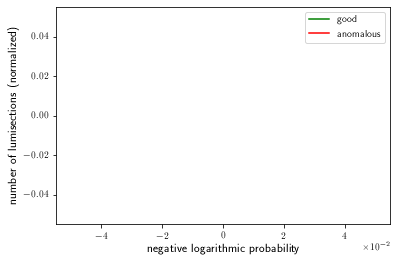

/eos/home-i01/k/khowey/SWAN_projects/ML4DQMDC-PixelAE/KH-AutoencoderTest/../utils/plot_utils.py:747: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  if xaxlog: ax.set_xscale('log')


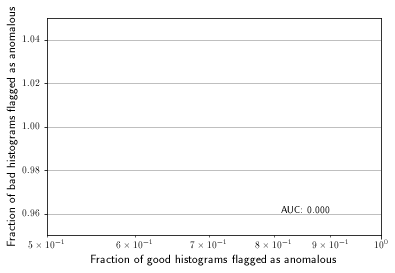

Selected logprob threshold of nan
Accuracy: 0.5
Precision: nan
Recall: 0.0
F-Measure: nan


/tmp/ipykernel_7786/957400560.py:58: RuntimeWarning: invalid value encountered in double_scalars
  precision = tp / (tp + fp)


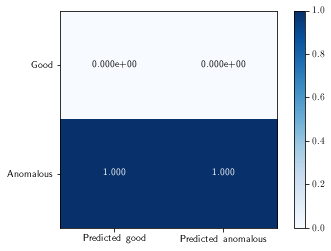

In [48]:
logprob_threshold, labels2 = evaluate_autoencoders_combined(logprob_good, logprob_bad, fmBiasFactor, wpBiasFactor)

In [35]:
def evaluate_autoencoders_combined_fix(logprob_good, logprob_bad, fmBiasFactor, wpBiasFactor, labels2):
    labels = labels2
    labels_good = np.zeros(len(logprob_good)) # background: label = 0
    labels_bad = np.ones(len(logprob_bad)) # signal: label = 1
    
    badMin = min(np.where(logprob_bad != -np.inf, logprob_bad, -1))
    goodMax = max(np.where(logprob_good != np.inf, logprob_good, 10001))
    
    logprob_good = np.where(logprob_good != np.inf, logprob_good, goodMax)
    logprob_bad = np.where(logprob_bad != -np.inf, logprob_bad, badMin)
    
    # These only take effect if a histogram is grossly misclassified
    logprob_good[logprob_good == -np.inf] = badMin
    logprob_bad[logprob_bad == np.inf] = goodMax
    
    scores = np.concatenate(tuple([-logprob_good,-logprob_bad]))
    scores = aeu.clip_scores( scores )
    
    avSep = np.mean(logprob_good) - np.mean(logprob_bad)
    
    print('Average Separation: ' + str(avSep))
    
    # Setting a threshold, below this working point defines anomalous data
    # Average is biased towards better recall per user specifications
    logprob_threshold = (1/(wpBiasFactor + 1)) * (wpBiasFactor*np.mean(logprob_good) + np.mean(logprob_bad))
    # Or set manual
    # logprob_threshold = 400 
    
    
    (fig, ax) = pu.plot_score_dist(scores, labels2, siglabel='anomalous', sigcolor='r', 
                       bcklabel='good', bckcolor='g', 
                       nbins=200, normalize=True,
                       xaxtitle='negative logarithmic probability',
                       yaxtitle='number of lumisections (normalized)',
                       doshow=False)
    plt.axvline(x=-logprob_threshold, color='b', label='WP')
    plt.show()
      
    # Plot ROC curve for analysis
    auc = aeu.get_roc(scores, labels2, mode='geom', doprint=False)
    
    (_, _, _, tp, fp, tn, fn) = aeu.get_confusion_matrix(scores, labels2,-logprob_threshold)
    print('Selected logprob threshold of ' + str(logprob_threshold))
    
    # Get metrics for analysis
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_measure = (1 + fmBiasFactor * fmBiasFactor) * ((precision * recall) / ((fmBiasFactor * fmBiasFactor * precision) + recall)) 
    
    print('Accuracy: ' + str(accuracy))
    print('Precision: ' + str(precision))
    print('Recall: ' + str(recall))
    print('F-Measure: ' + str(f_measure))
    
    return logprob_threshold

Average Separation: nan


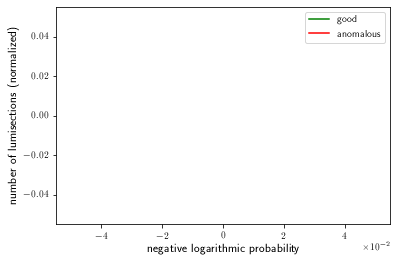

/eos/home-i01/k/khowey/SWAN_projects/ML4DQMDC-PixelAE/KH-AutoencoderTest/../utils/plot_utils.py:747: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  if xaxlog: ax.set_xscale('log')


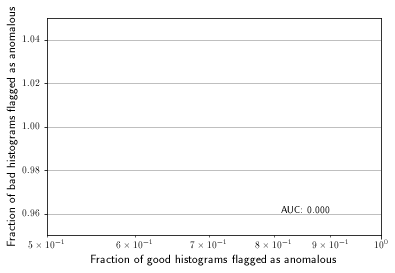

Selected logprob threshold of nan
Accuracy: 0.5
Precision: nan
Recall: 0.0
F-Measure: nan


/tmp/ipykernel_7786/3747684355.py:47: RuntimeWarning: invalid value encountered in double_scalars
  precision = tp / (tp + fp)


nan

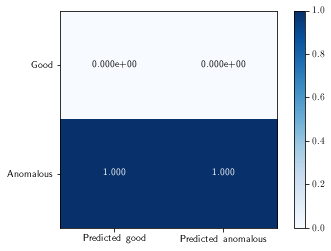

In [36]:
evaluate_autoencoders_combined_fix(logprob_good, logprob_bad, fmBiasFactor, wpBiasFactor, labels2)